# Denoising the biosignals from fMRI gradients




In [1]:
#dependencies
import numpy as np
import pandas as pd
import neurokit as nk 
import matplotlib.pyplot as plt

In [2]:
# Make figures a bit bigger
%pylab inline
pylab.rcParams['figure.figsize'] = (40.0, 30.0)  
# avoid error messages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Populating the interactive namespace from numpy and matplotlib


### Path to folder and subfolders
This should follow TIER's protocol and valid according to BIDS.
Reference to consider : https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/06-physiological-and-other-continous-recordings.html 

In [3]:
dir_path = 'C:\\Users\\sangfrois\\physiological-signals\\original-data\\'
subject_path = 'sub-01\\'
exp_path = 'ses-video001\\'

### Read .acq files with Neurokit
The author of neurokit built this function using bioread's repo (https://github.com/uwmadison-chm/bioread/tree/master/bioread) 
It supports data coming from BIOPAC instruments software v5.0 and older

**I should find a way to automatize the data import; do batch preprocessing**

Script of **read_acqknowledge** function can be found under the name bio_data.py in nk library


In [4]:
#read data - .head() returns the dataframe with dict keys as header

Biosignals_dataFrame, sampling_rate = nk.read_acqknowledge(dir_path+subject_path+exp_path+'sub-01_ses-video001-ocean11.acq', return_sampling_rate=True)
Biosignals_dataFrame.head()

GSR-EDA100C-MRI   PPG100C   ECG100C       TTL  \
2019-08-28 08:41:07.021872         8.964539 -0.069885 -0.173187  0.000000   
2019-08-28 08:41:07.022072         8.966065 -0.069580 -0.173035  0.000305   
2019-08-28 08:41:07.022272         8.964539 -0.069885 -0.173035  0.000305   
2019-08-28 08:41:07.022472         8.964539 -0.069885 -0.173340  0.000610   
2019-08-28 08:41:07.022672         8.966065 -0.070496 -0.173492  0.000305   

                            Custom, HLT100C - A 6  
2019-08-28 08:41:07.021872               0.672913  
2019-08-28 08:41:07.022072               0.673828  
2019-08-28 08:41:07.022272               0.672607  
2019-08-28 08:41:07.022472               0.674438  
2019-08-28 08:41:07.022672               0.671692

In [5]:
ttl = Biosignals_dataFrame['TTL']

## Parse the data

**This part of the Notebook separates the signal in blocks of MR recording session based on TTL**



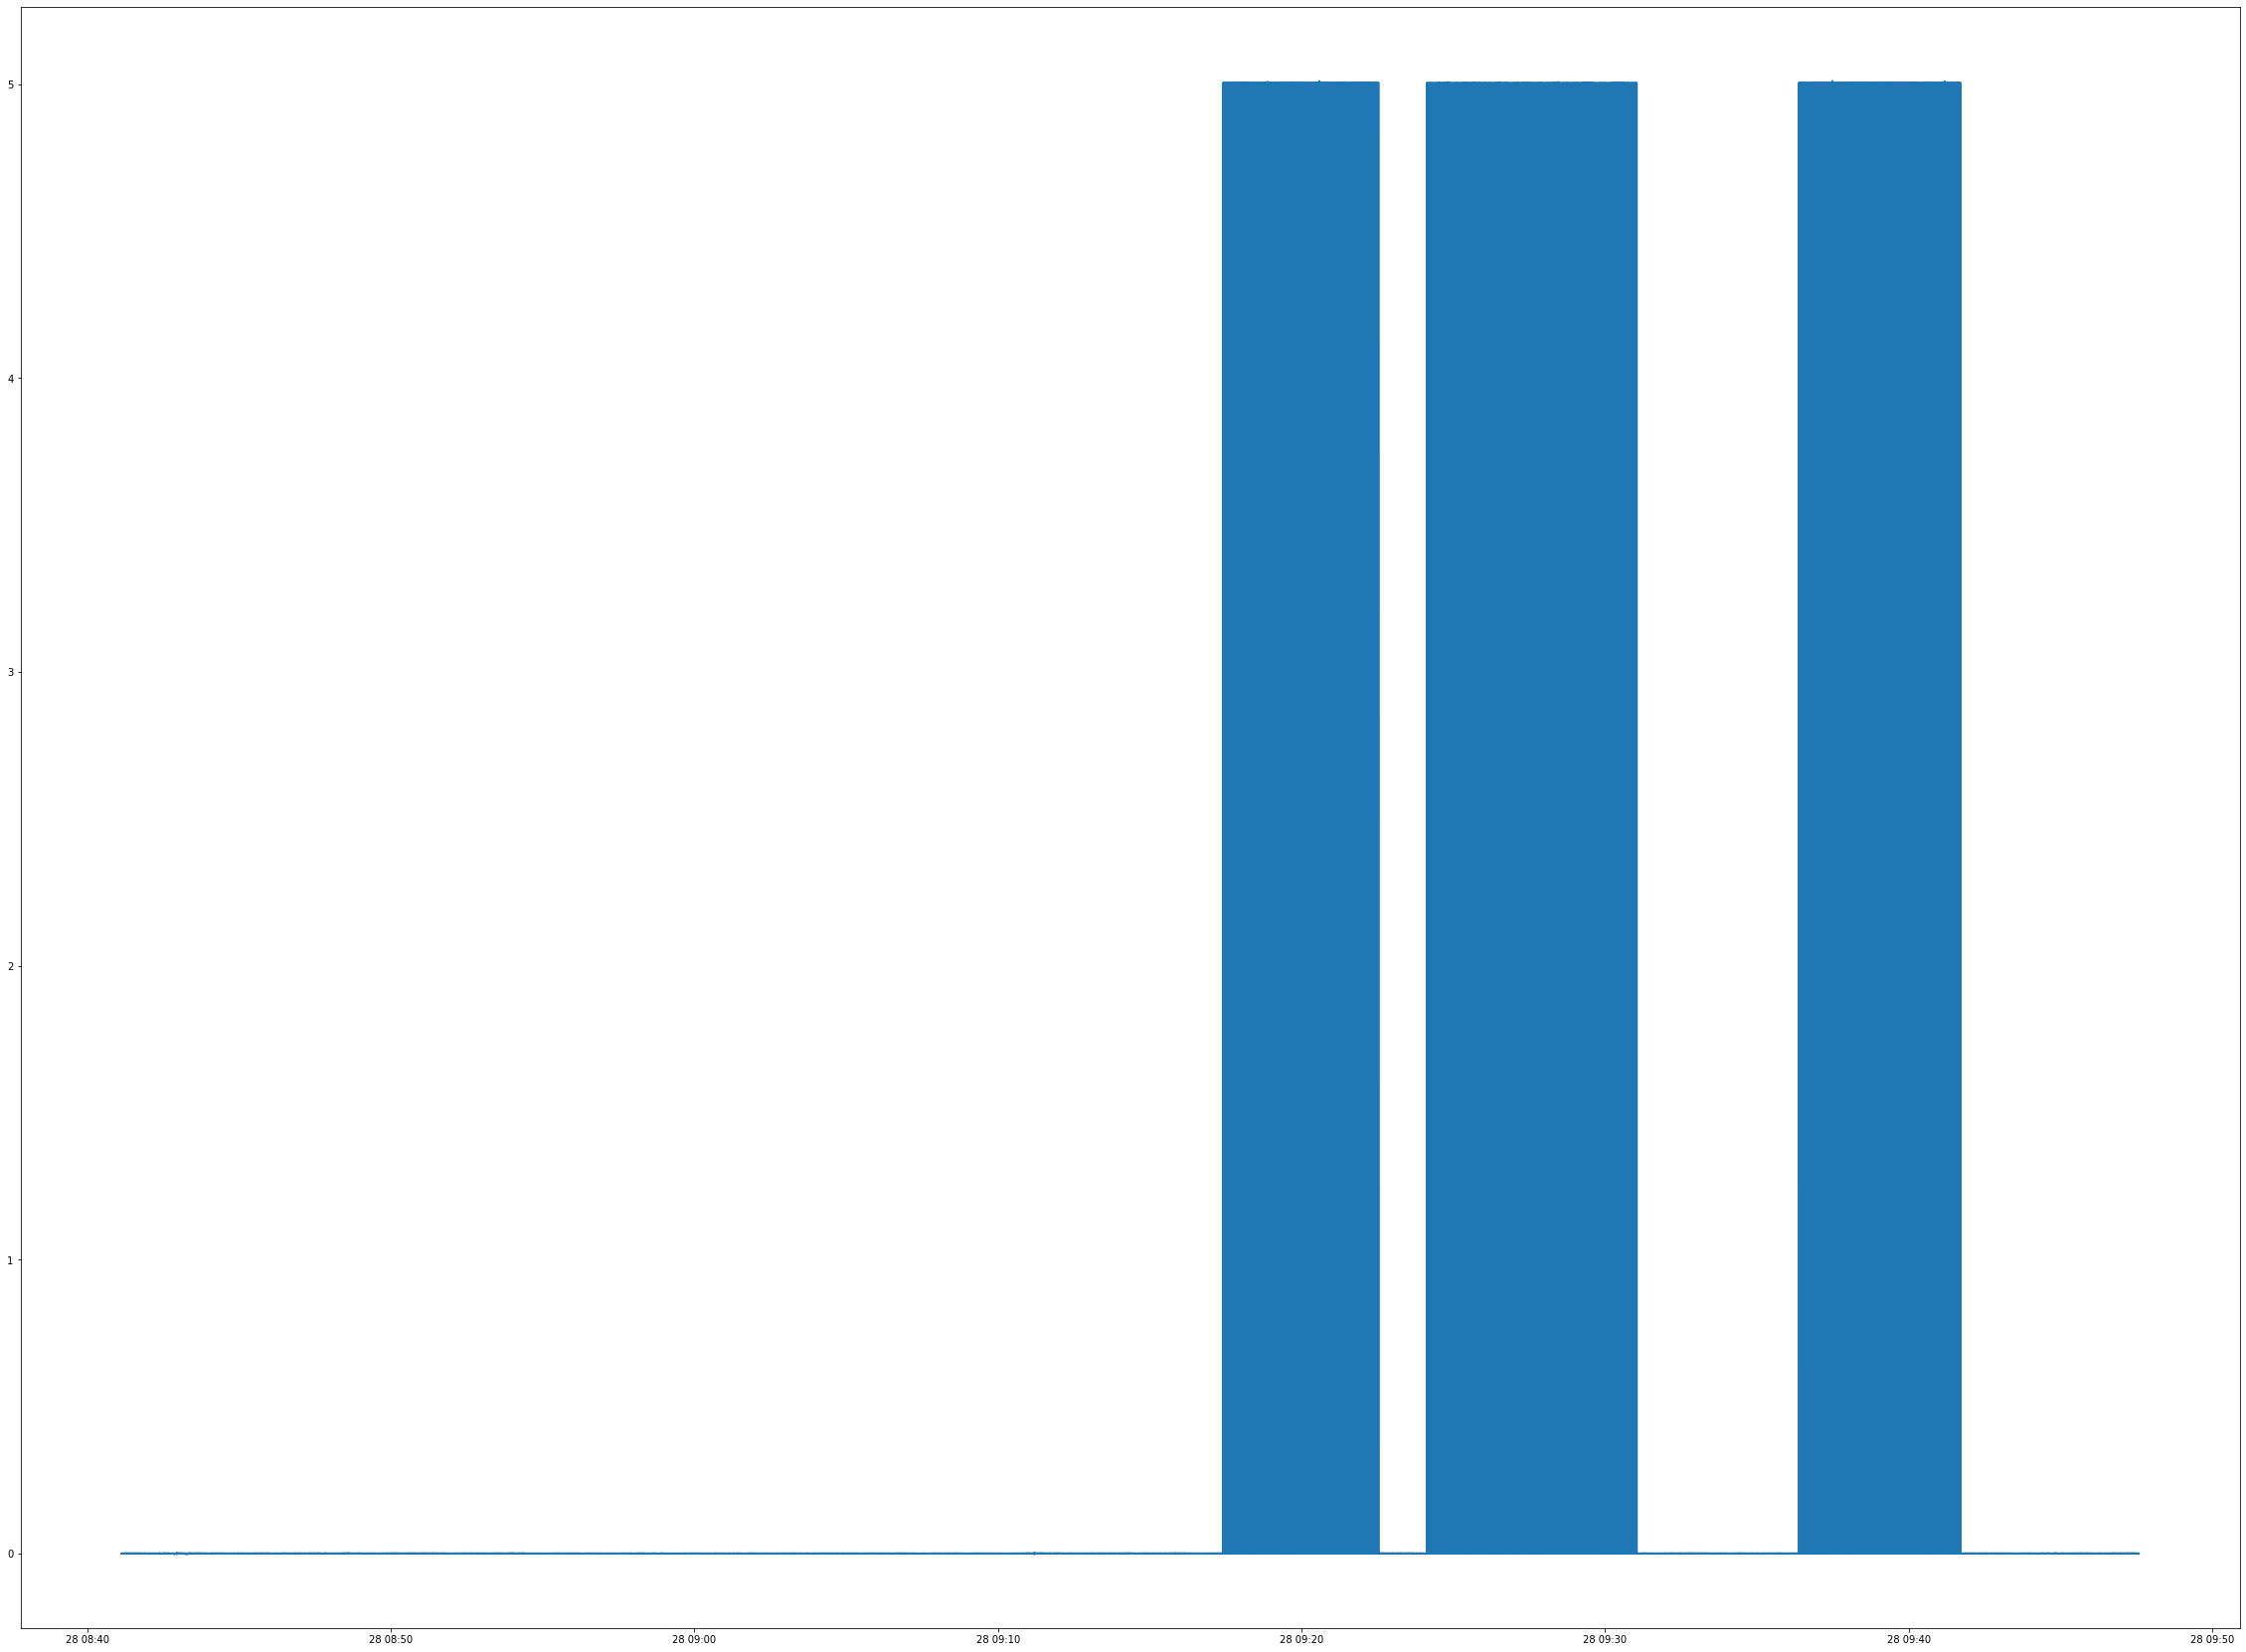

In [6]:
# Visualize the TTL signal on which we'll perform the parsing

plt.plot(ttl)

### Define start and end for  the recording session

* ___query_df___ represents every datapoints where TTL channel values are higher than 1, i.e. __the scanner is on__

* Problem is that we can't just take these indexes because __the period between two rows represents the repetition time__ of the scanner's triggers

* TTL values can be high (over 5) when doing structural (T1) sequences, i.e. around 5 mins

* TTL values can be high when doing BOLD (T2) sequences, i.e. should be 10 mins

*Start* and *End* represent the whole sanning session

*Delta_session* represents the length between the start and end time points

*block_len* is the a priori known minimum scanning block length

In [7]:
import datetime
from datetime import timedelta

query_df = Biosignals_dataFrame.query('TTL > 1')

start, end = query_df.index[[0, -1]]

delta_session = end-start
block_len = timedelta(minutes = 3)

### Define parsing indexes

1. If **delta** is over a priori known length of block, then query_df has multiple blocks
2. For loop looks in query_df
    1. If finds **timestamp values larger than TR period** between two adjacent time points ; pushes the two timestamps in a list
    2. else : ***error***

In [8]:
parse_list = []

if delta_session > block_len:
    
    tr_period = timedelta(seconds = 2)

    for time in range (len(query_df)-1) :
        
        time_delta = pd.to_datetime(query_df.index[time+1])-pd.to_datetime(query_df.index[time])
        
        if time_delta > tr_period:
            
            parse_start = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time])
            parse_end = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time+1])
            
            parse_list += [(parse_start, parse_end)]
        
    
    #Slice mutliple indexes
    #df.loc[('cobra', 'mark i'):('viper', 'mark ii')]
else:
        parse_list += [(start, end)]
print(parse_list)

[(Timestamp('2019-08-28 09:22:32.478597'), Timestamp('2019-08-28 09:24:07.409601')), (Timestamp('2019-08-28 09:31:03.022822'), Timestamp('2019-08-28 09:36:23.143838'))]


#### I end up with a list of Timestamps that goes like this :

parse_list = [(end of rec, start of next), (start of next rec, end of next rec), etc.]

### Keep the first segment before scanner is turned on and name blocks based on Timestamp list

* Block00 is always first index of Biosignal_dataframe to the last index of parse_list; **Biosignal_dataframe.index[0]** 'till **start**

* Block 01 is always from start to first index of parse_list ; **start** 'till **first index of parse_list**

* BlockLast is always last index of parse_list to end ; **parse_list[i][i]** 'till **end**

In [9]:
block00 = Biosignals_dataFrame[Biosignals_dataFrame.index[0]:start]
block01 = Biosignals_dataFrame[start:parse_list[0][0]]
block02 = Biosignals_dataFrame[parse_list[0][1]:parse_list[1][0]]
blockLast = Biosignals_dataFrame[parse_list[1][1]:end]


#blocks = [ block00, block01 ]
#for i in range(len(parse_list)):
 #   blocks += [Biosignals_dataFrame[parse_list[i][1]:parse_list[1+i][0]]] 
#blocks += 

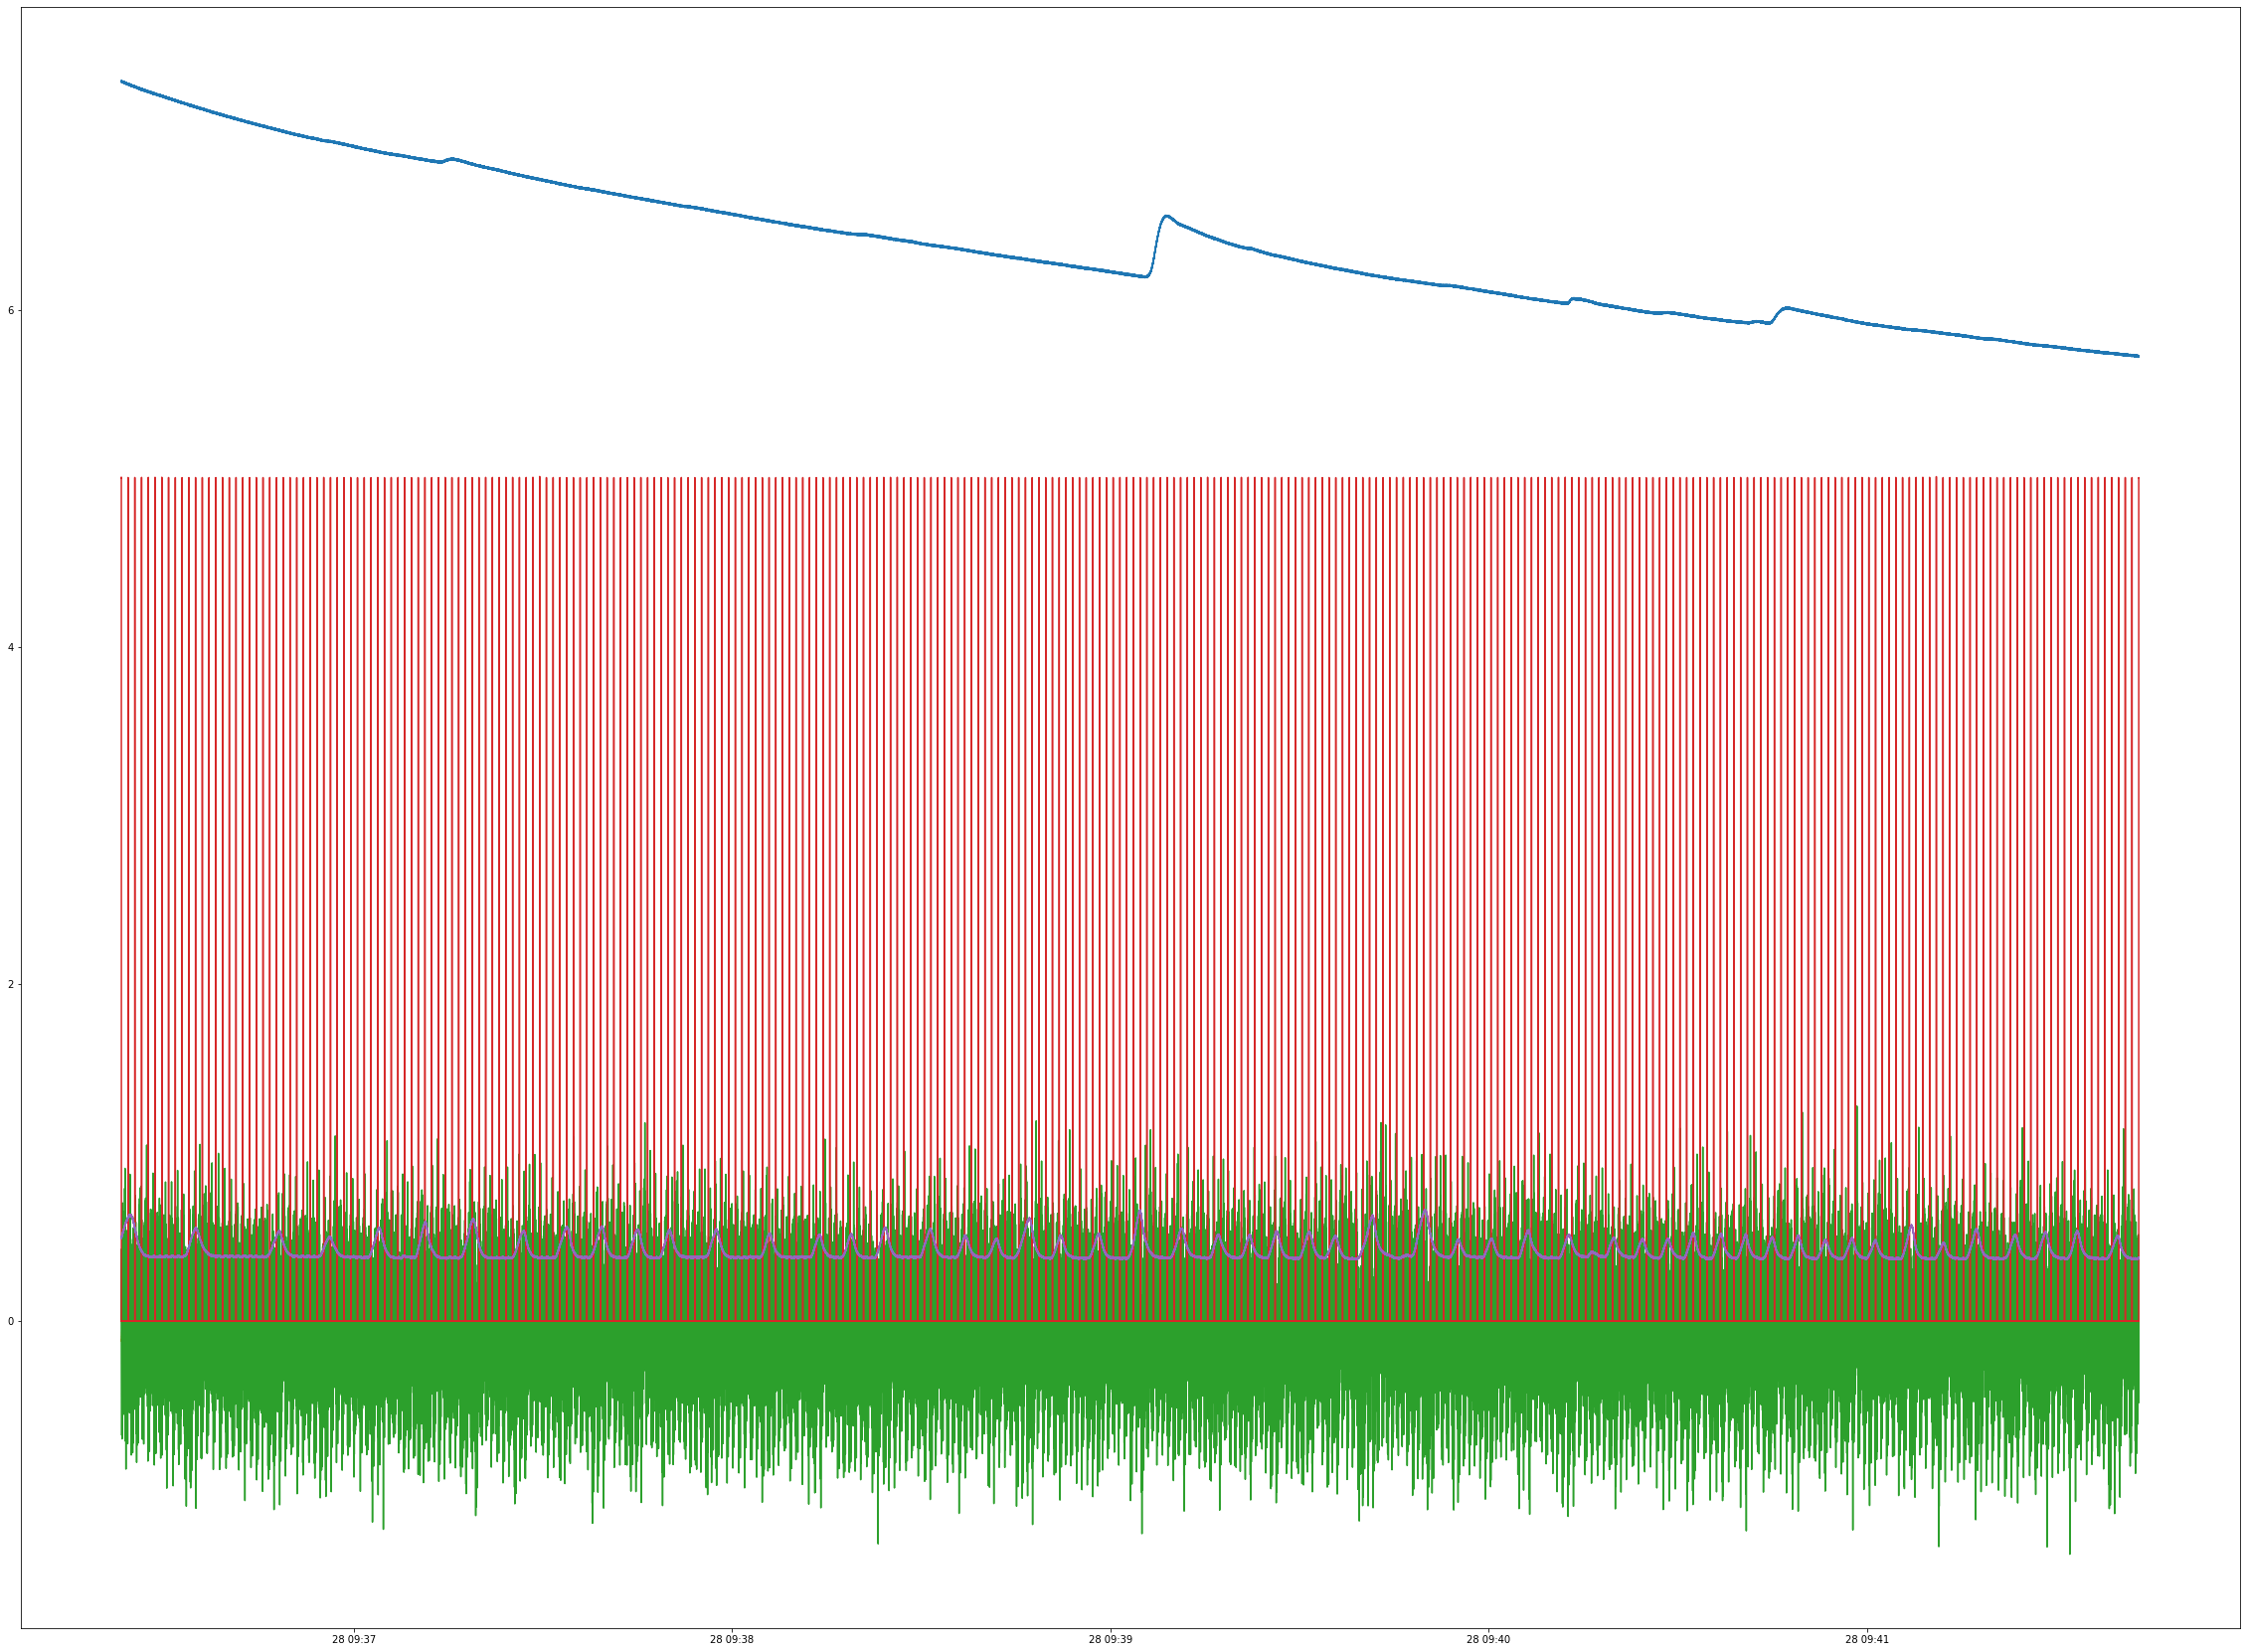

In [10]:
# plot the blocks
plt.plot(blockLast)

In [ ]:
# associate dict keys to variable names and get a sense of the content with .describe()
ppg = block00['PPG100C']
ecg = block00['ECG100C']
rsp = block00['Custom, HLT100C - A 6']
ttl = block00['TTL']
eda = block00['EDA100C']



# define threshold value for ttl channel that corresponds to when the scanner is running


In [20]:
ecg_block01 = block01['ECG100C']
rsp_block01 = block01['Custom, HLT100C - A 6']

## Interference description :

ECG signals recorded in fMRI are principally polluted by gradient artifacts related to the radio-frequency pulse and magnetism of scanner's bore. The Neuromod team implemented a Gradient-Echo multi-band sequence (i.e. multiple slices at a time). Simple maths :

- 60-slices sequence with multi-band factor of 4 and 1,490s repetition time : 60/4 = 15 shots per TR. 

- Gradients per TR? 15/1490 = 10.067 Hz. So approximately 100ms separate adjacent gradients.

Other sources of interference include : 

- Muscle contraction ; movement ; moving cables ; respiration-induced baseline fluctuations

In [22]:

ecg_preproc = nk.ecg_preprocess(ecg, rsp, sampling_rate=sampling_rate, filter_type='FIR', filter_band='bandpass', filter_frequency=[3, 17], 
                          segmenter='pekkanen')
ecg_preproc.head()

C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


NameError: name 'ecg_preproc' is not defined

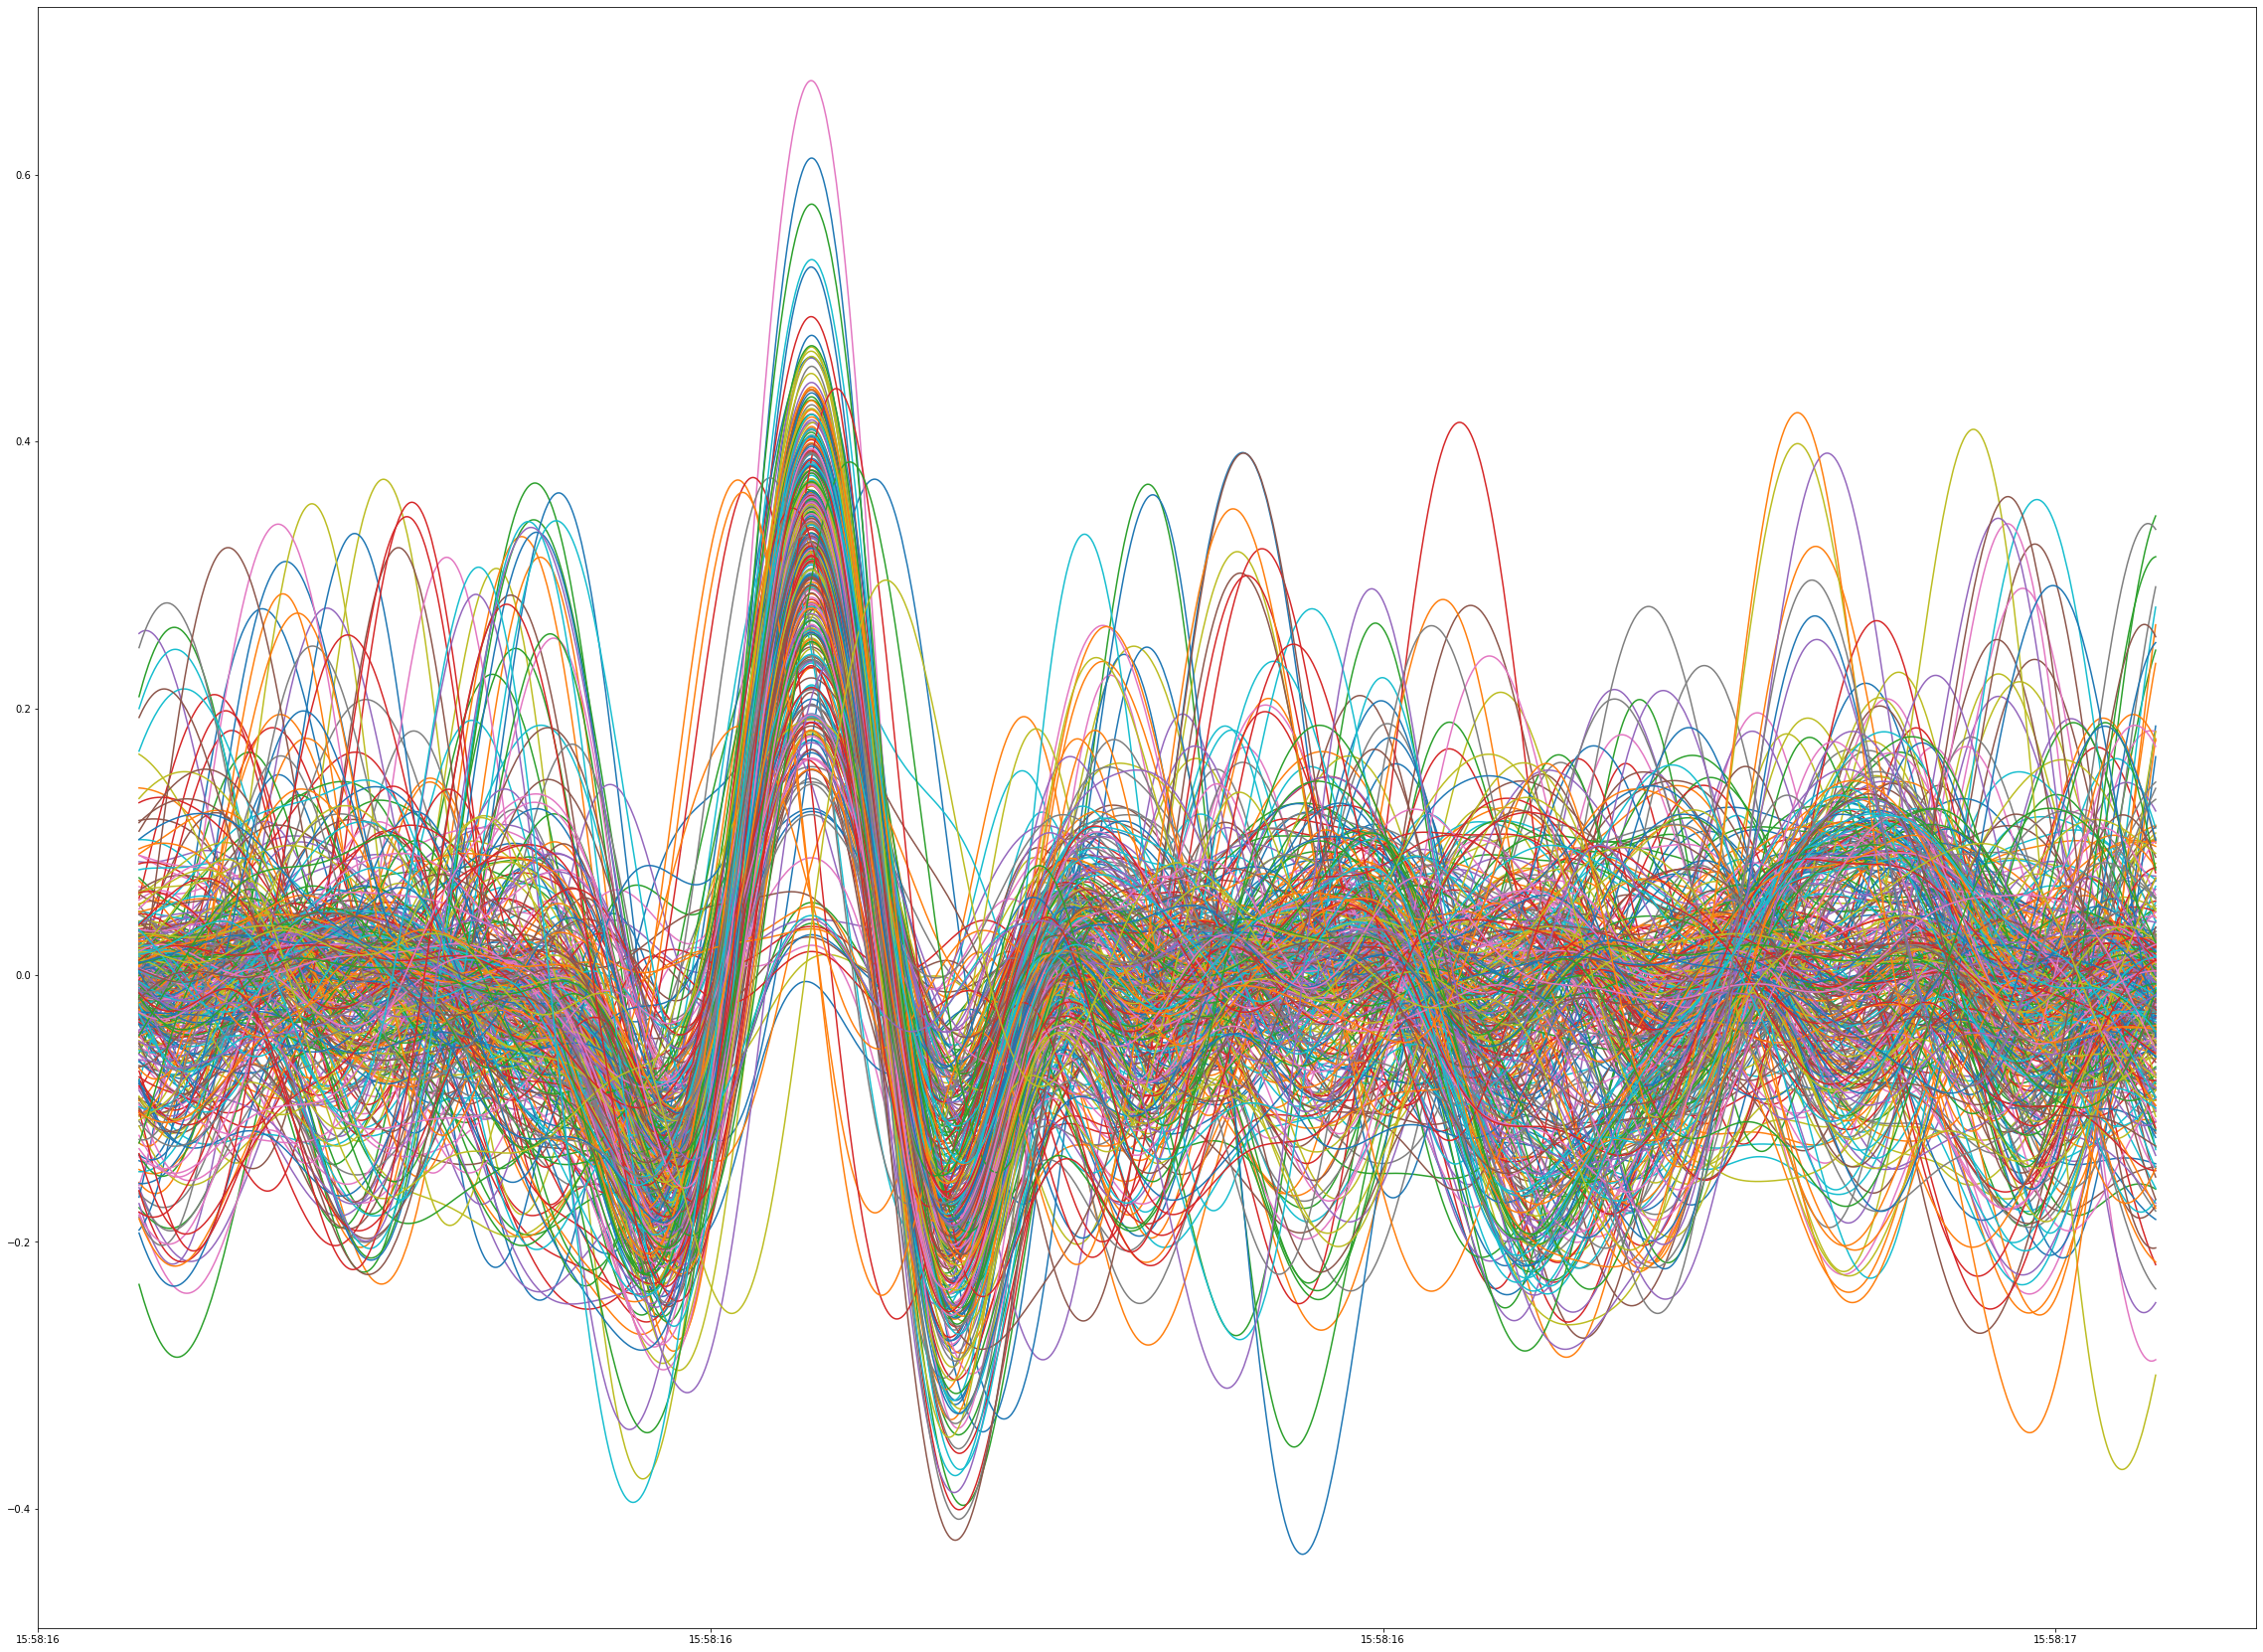

In [32]:
plt.plot(ecg_proc['ECG']['Cardiac_Cycles'])